# Journey to Springfield

The Fox Broadcasting Company needs assistance with processing their content. The task is to train convolutional network, so it can classify all characters living in Springfield.


 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



## Installing dependencies

In [ ]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.1 MB/s eta 0:00:48tcmalloc: large alloc 1147494400 bytes == 0x660be000 @  0x7f71fa21b615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████████████████| 887.4 MB 1.7 kB/s 
     |████████████████████████████████| 24.2 MB 12.6 MB/s 
     |████████████████████████████████| 317.1 MB 30 kB/s 
     |████████████████████████████████| 849 kB 72.4 MB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
     |████████████████████████████████| 21.0 MB 25.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully un

In [ ]:
# Let's verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
#checking Pillow and Torch Versions
import PIL
print(PIL.PILLOW_VERSION)

print(torch.__version__)

7.1.2
1.13.1+cu117


<ipython-input-3-bfe0a2643f95>:3: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  print(PIL.PILLOW_VERSION)


**Unpacking the ZIP archive from Google Drive folder**

In [ ]:
#ZIP file is stored on my Google Drive
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#Unzip the archive
!unzip -q /content/gdrive/My\ Drive/ML/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


Our test contains 990 pictures. We should predict the class for every picture.

In [ ]:
import pickle
import numpy as np
import copy
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import lr_scheduler
from tqdm.auto import tqdm, trange
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline

# ignoring warnings in sklearn do display pictures perfectly well
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# different modes of Data set 
DATA_MODES = ['train', 'val', 'test']
# all pictures will be rescaled to 224x224 px
RESCALE_SIZE = 224
# working on GPU
DEVICE = torch.device("cuda") if train_on_gpu else torch.device("cpu")


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Below I'm using the dataset wrapper for more convinience.

`ToTensor` method converts  PIL Image with parameters in range [0, 255] (pixels) to FloatTensor of size (C x H x W) [0,1] , then scaling is performed:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       where constants - are mean and standard deviation for each channel based on ImageNet

Method __getitem__ is overidden to make it easier to operate with data structure.
Also LabelEncoder is used to convert string class label to class id and back. As pictures are captured directly from video, picture size is different, that's why all pictures should be adjusted to the same size.

In [ ]:
'''
Special class for augmentation.
It is used during train mode to make picture squared if it's original shape is rectangle. 
During multiple tries I've figured out that squared characters are classified better 
than flattened or stretched images.
'''

class SquarePadTransform:
    def __call__(self, image):
        w, h = image.size
        if w != h:
            max_wh = np.max([w, h])
            hp = int((max_wh - w) / 2)
            vp = int((max_wh - h) / 2)
            padding = (hp, vp, hp, vp)
            return transforms.functional.pad(image, padding, 0, 'constant')
        else:
            return image         

In [ ]:
from torchvision.transforms.transforms import RandomRotation

"""
Dataset with pictures. It loads pictures from folders in parallel,
scales them and converts to PyTorch tensors
"""

class SimpsonsDataset(Dataset):
    def __init__(self, files, mode, use_augmentation = False):
        super().__init__()
        # list of files to be loaded
        self.files = sorted(files)
        # working mode
        self.mode = mode
        # flag indicates whether augmentations should be applied
        # the flag is used in Train mode only 
        self.use_augmentation = self.mode == 'train' and use_augmentation

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        if self.use_augmentation:
            # when "use_augmentation" is True, first step - make picture squared
            # then apply flip with 50% probability
            # last step is random crop & resize to 224 x 224
            transform = transforms.Compose([
              SquarePadTransform(),
              transforms.RandomHorizontalFlip(p = 0.5),
              transforms.RandomResizedCrop(size = (RESCALE_SIZE, RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:  
            #transforming picture to PyTorch Tensor and doing normalization
            transform = transforms.Compose([
              # if it is VAL dataset or "use_augmentation" = False on train data
              # then we do Resize & Normalize only                              
              transforms.Resize(size = (RESCALE_SIZE, RESCALE_SIZE)),                              
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
            
    # Method returns original picture without augmentations
    # Method is used when it is needed to compare original picture 
    # and augmented picture  
    def __get_orig_item__(self, index):
        transform = transforms.Compose([
              transforms.Resize(size = (RESCALE_SIZE, RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

print('Train size:', len(train_files))
print('Val size:', len(val_files))
print('Test size:', len(test_files))

Train size: 15699
Val size: 5234
Test size: 991


In [ ]:
# splitting train & val files names

train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]

# checking our "train" dataset whether it is balanced or not
# there are some classes "lionel_hutz", "disco_stu", "troy_mcclure" 
# with just 2-5 pictures for each class
# Training on 2 pictures seems impossible. How to manage that?

# Let's use duplicates, so that every class has at least 100 pictures.
# Duplicates are OK, since we use random augmentations and same pictures will be
# augmented differently during the training phase. 
# So NN decides these are different pictures. 
sorted(list(zip(*np.unique(train_labels, return_counts = True))), key = lambda x: x[1])

[('lionel_hutz', 2),
 ('disco_stu', 6),
 ('troy_mcclure', 6),
 ('miss_hoover', 13),
 ('fat_tony', 20),
 ('gil', 20),
 ('otto_mann', 24),
 ('sideshow_mel', 30),
 ('agnes_skinner', 32),
 ('rainier_wolfcastle', 34),
 ('cletus_spuckler', 35),
 ('snake_jailbird', 41),
 ('professor_john_frink', 49),
 ('martin_prince', 53),
 ('patty_bouvier', 54),
 ('ralph_wiggum', 67),
 ('carl_carlson', 74),
 ('selma_bouvier', 77),
 ('barney_gumble', 80),
 ('groundskeeper_willie', 91),
 ('maggie_simpson', 96),
 ('waylon_smithers', 136),
 ('mayor_quimby', 185),
 ('lenny_leonard', 233),
 ('nelson_muntz', 269),
 ('edna_krabappel', 343),
 ('comic_book_guy', 352),
 ('kent_brockman', 373),
 ('apu_nahasapeemapetilon', 467),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('chief_wiggum', 739),
 ('milhouse_van_houten', 809),
 ('charles_montgomery_burns', 895),
 ('principal_skinner', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson', 1015),
 ('moe_szyslak'

In [ ]:
from itertools import groupby
from operator import itemgetter

# useful function to extend number of files for classes where files_count < MIN_PER_CLASS

def do_oversampling(min_per_class, list_files, list_labels):
    
    sorter = sorted(list(zip(list_labels, list_files)), key=itemgetter(0))
    grouper = groupby(sorter, key=itemgetter(0))
    
    # creating dictionary where key = class, value = list of files
    dct_list_by_class = {k: list(map(itemgetter(1), v)) for k, v in grouper}

    updated_files = []

    # iterate through the dictionary
    # if number of files per class < min_per_class, then fill the list of files
    # with duplicates 
    for class_name, class_files in dct_list_by_class.items():
        
        class_len = len(class_files)
      
        if class_len < min_per_class:
            # time to extend
            dct_list_by_class[class_name] = (class_files * (min_per_class // class_len + 1))[:min_per_class]
      
        #append files to list of updated_files
        updated_files.extend(dct_list_by_class[class_name])

    #after updated_files are filled -> calculate updated labels
    updated_labels = [path.parent.name for path in updated_files]  
    return updated_files, updated_labels

In [ ]:
# Here we decide whether we need oversampling or not
# Finally it became better with oversampling 
# and min number of pictures per class = 100
MIN_PER_CLASS = 100
APPLY_OVERSAMPLING = True

if APPLY_OVERSAMPLING:
    new_train_files, new_train_labels = do_oversampling(MIN_PER_CLASS, train_files, train_labels)
else:
    new_train_files, new_train_labels = train_files, train_labels

In [ ]:
#checking whether the updated train dataset is balanced

sorted(list(zip(*np.unique(new_train_labels, return_counts = True))), key = lambda x: x[1])

#Wow, much better now!

[('agnes_skinner', 100),
 ('barney_gumble', 100),
 ('carl_carlson', 100),
 ('cletus_spuckler', 100),
 ('disco_stu', 100),
 ('fat_tony', 100),
 ('gil', 100),
 ('groundskeeper_willie', 100),
 ('lionel_hutz', 100),
 ('maggie_simpson', 100),
 ('martin_prince', 100),
 ('miss_hoover', 100),
 ('otto_mann', 100),
 ('patty_bouvier', 100),
 ('professor_john_frink', 100),
 ('rainier_wolfcastle', 100),
 ('ralph_wiggum', 100),
 ('selma_bouvier', 100),
 ('sideshow_mel', 100),
 ('snake_jailbird', 100),
 ('troy_mcclure', 100),
 ('waylon_smithers', 136),
 ('mayor_quimby', 185),
 ('lenny_leonard', 233),
 ('nelson_muntz', 269),
 ('edna_krabappel', 343),
 ('comic_book_guy', 352),
 ('kent_brockman', 373),
 ('apu_nahasapeemapetilon', 467),
 ('sideshow_bob', 658),
 ('abraham_grampa_simpson', 685),
 ('chief_wiggum', 739),
 ('milhouse_van_houten', 809),
 ('charles_montgomery_burns', 895),
 ('principal_skinner', 895),
 ('krusty_the_clown', 904),
 ('marge_simpson', 968),
 ('bart_simpson', 1006),
 ('lisa_simpson'

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(new_train_files, mode='train', use_augmentation = True)

Let's look at our characters inside dataset

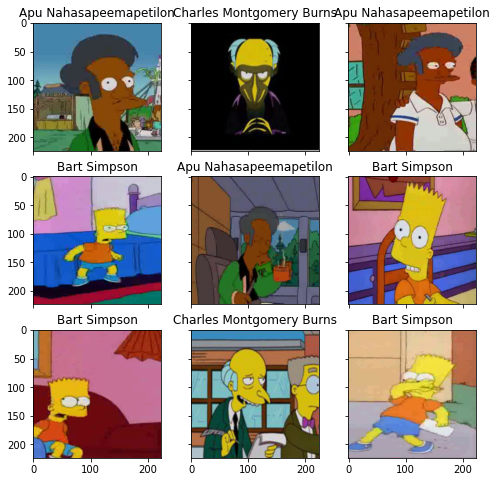

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Visualizing Augmentations

Visualization of different Augmentations allows to double check whether particular picture modification makes sense. Here is the code to compare original and augmented images. 

For example, Random rotation is meaningless for this classification task as faces' position is always straight. Data cannot contain any faces upside down

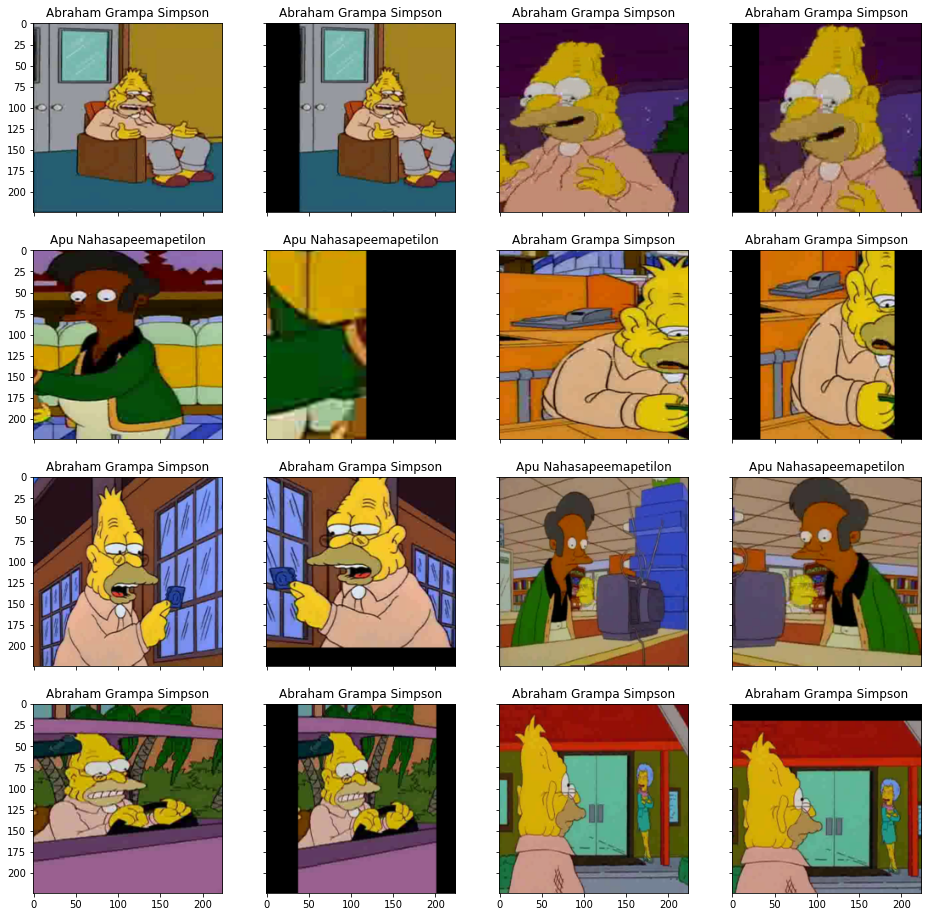

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(16, 16), \
                        sharey=True, sharex=True)

sample_size = (4 * 4) // 2
random_idx = list(map(int, np.random.uniform(0,1000, sample_size)))

for i, fig_x in enumerate(ax.flatten()):
    random_characters = random_idx[i // 2]
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    if (i % 2 == 0):
        im_val, _ = train_dataset.__get_orig_item__(random_characters)
    imshow(im_val.data.cpu(), \
           title=img_label,plt_ax=fig_x)

## Building Neural Network

1st try. Let's start from simple Convolutional NN with the following layers:

1. input size: 3x224x224 
2. output size:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. output: 96x5x5


In [ ]:
#Very simple CNN

class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
#2nd CNN - with Batch Norm

class ModelBatchNorm(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, epoch_index):
    
    model.train(True) #just in case - decided to switch model to train mode
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    batches_total = len(train_loader) #returns number of batches
    
    #displaying pretty progress bar for each epoch
    with tqdm(desc=f"train epoch {epoch_index}:", leave=False, total=batches_total) as pbar_train:
    
        for inputs, labels in train_loader:

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)
            
            pbar_train.update(1)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion, epoch_index):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    #displaying pretty progress bar for each epoch
    with tqdm(desc=f"eval epoch {epoch_index}:", leave=False, total=len(val_loader)) as pbar_val:
            
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            processed_size += inputs.size(0)
            pbar_val.update(1)
    
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, \
          use_scheduler = False, opt = None):
    
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}, \
    best_val_acc {best_val_acc:0.4f}"

    # adding storage for best weights, will be finally used 
    # when training for all epochs is finished
    best_model_wts = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        # optimizer can be passed from outside (used for Transfer Learning)
        # tried Adam, AdamW and amsgrad. 
        # Best results: amsgrad
        if opt is None:
            opt = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999) \
                                    , weight_decay=0.01, amsgrad = True)
        
        criterion = nn.CrossEntropyLoss()

        # Use Learning Rate scheduler when use_scheduler = True
        # multiple learning_rate by 0.1 every 3 epochs
        if use_scheduler:
            scheduler = lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)
        else:
            scheduler = None

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, epoch)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, epoch)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            #remember model weights if current accuracy is better than "best_acc"
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, \
                                           v_acc=val_acc, best_val_acc = best_acc))
            
             # if scheduler is defined, do LR step after every epoch
            if scheduler is not None:
                scheduler.step()
            
    # finally - let's load the best model weights
    model.load_state_dict(best_model_wts)        
            
    return model, history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

### Part 1 - Simple CNN with Batch Norm

In [ ]:
n_classes = len(np.unique(train_val_labels))
model_bn_cnn = ModelBatchNorm(n_classes).to(DEVICE)

print("we will classify :{}".format(n_classes))
print(model_bn_cnn)

we will classify :42
ModelBatchNorm(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, 

**Run the NN training:**

*   10 epochs
*   Optimizer AmsGrad is initialized inside "train" method
*   without LR scheduler



In [ ]:
model_bn_cnn, history = train(train_dataset, val_dataset, model=model_bn_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train epoch 0::   0%|          | 0/264 [00:00<?, ?it/s]

loss 2.6214862979986004


eval epoch 0::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 2.6215     val_loss 1.5592 train_acc 0.3301 val_acc 0.5806,     best_val_acc 0.5806


train epoch 1::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.9449548364779272


eval epoch 1::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 1.9450     val_loss 1.1964 train_acc 0.4871 val_acc 0.6674,     best_val_acc 0.6674


train epoch 2::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.6065952306811222


eval epoch 2::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 1.6066     val_loss 0.9367 train_acc 0.5716 val_acc 0.7455,     best_val_acc 0.7455


train epoch 3::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.3931580271513444


eval epoch 3::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 1.3932     val_loss 0.8336 train_acc 0.6230 val_acc 0.7767,     best_val_acc 0.7767


train epoch 4::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.2701667950399602


eval epoch 4::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 1.2702     val_loss 0.7458 train_acc 0.6605 val_acc 0.7979,     best_val_acc 0.7979


train epoch 5::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.1881963985422794


eval epoch 5::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 1.1882     val_loss 0.6942 train_acc 0.6809 val_acc 0.8082,     best_val_acc 0.8082


train epoch 6::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.1331040809337258


eval epoch 6::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 1.1331     val_loss 0.6681 train_acc 0.6951 val_acc 0.8259,     best_val_acc 0.8259


train epoch 7::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.0721900906355362


eval epoch 7::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 008 train_loss: 1.0722     val_loss 0.6350 train_acc 0.7109 val_acc 0.8334,     best_val_acc 0.8334


train epoch 8::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.02067697950283


eval epoch 8::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 009 train_loss: 1.0207     val_loss 0.6072 train_acc 0.7254 val_acc 0.8403,     best_val_acc 0.8403


train epoch 9::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.9999327450964217


eval epoch 9::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.9999     val_loss 0.5769 train_acc 0.7286 val_acc 0.8498,     best_val_acc 0.8498


Let's plot the learning curves

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

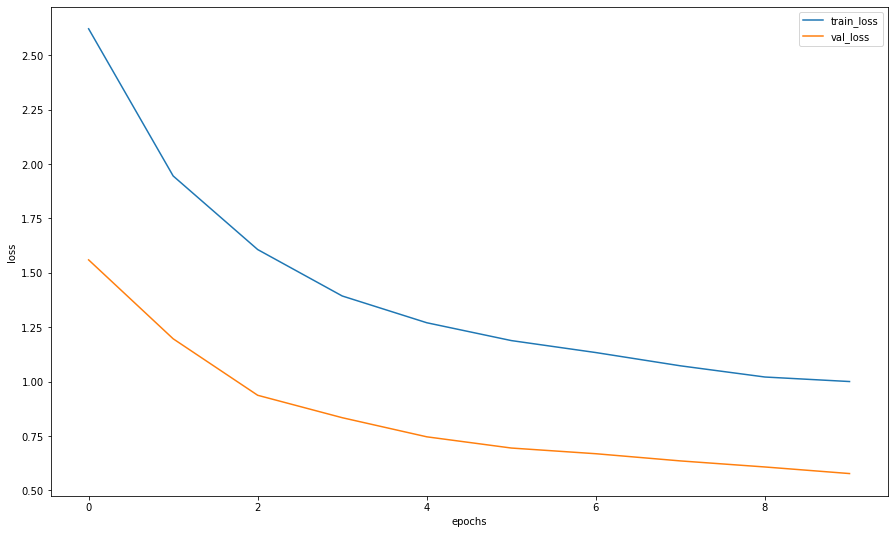

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# Let's calculate F1 score on VAL dataset

idxs = list(range(len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_bn_cnn, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

# we need to use label_encoder here, otherwise F1 score returns an error
actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

#adding average='micro', otherwise F1 score cannot be calculated
f1_score(actual_labels, preds_class, average='micro')

0.8498280473824991

**Summary:** score is not bad ~ 0.85, but it is far from requested score = 0.97.

If I decide to increase the number of epochs, it shouldn't improve score drammatically (see learning curve - losses curves become flat at the end). Also, it may lead to overfitting.

I can try different approach. I can use pretrained NN and apply Transfer Learning technique

### Part 2 - VGG 16 batch norm & transfer learning

In [ ]:
#let's download pretrained VGG 16 BN 

vgg16_model = models.vgg16_bn(pretrained=True)

print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
n_classes = len(np.unique(train_val_labels))

# Tried just classifier params adjusting with all features freezed
# Best Results with Feature layears to Unfreeze = 20
layers_to_unfreeze = 20

if layers_to_unfreeze > 0:
    for param in vgg16_model.features[:-layers_to_unfreeze].parameters():
        param.requires_grad = False
else:
    # let's try to freeze all pretrained weights in VGG
    for param in vgg16_model.parameters():
        param.requires_grad = False

#replacing whole FC classifier with one layer
vgg16_model.classifier = nn.Linear(25088, n_classes)

if train_on_gpu:
    vgg16_model = vgg16_model.cuda()

opt_params = list(vgg16_model.classifier.parameters())

if layers_to_unfreeze > 0:
    opt_params.extend(list(vgg16_model.features[-layers_to_unfreeze:].parameters()))

custom_opt = torch.optim.AdamW(opt_params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, amsgrad = True)

print("we will classify :{}".format(n_classes))
print(vgg16_model)

we will classify :42
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [ ]:
# let's check which parameters we learn !!!
params_to_update = vgg16_model.parameters()
print("VGG 16 Params to learn:")

params_to_update = []
for name, param in vgg16_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Here we print out number of params
# passed to optimizer to learn 
print('\nVGG 16 opt params size =', 
      len(custom_opt.__getstate__()['param_groups'][0]['params']))

VGG 16 Params to learn:
	 features.24.weight
	 features.24.bias
	 features.25.weight
	 features.25.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.34.weight
	 features.34.bias
	 features.35.weight
	 features.35.bias
	 features.37.weight
	 features.37.bias
	 features.38.weight
	 features.38.bias
	 features.40.weight
	 features.40.bias
	 features.41.weight
	 features.41.bias
	 classifier.weight
	 classifier.bias

VGG 16 opt params size = 26


In [ ]:
vgg16_model, history = train(train_dataset, val_dataset, model=vgg16_model, epochs=10, batch_size=64, \
                                use_scheduler = True, opt = custom_opt)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train epoch 0::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.6702008165456586


eval epoch 0::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.6702     val_loss 0.7850 train_acc 0.5701 val_acc 0.8065,     best_val_acc 0.8065


train epoch 1::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.8726726726442796


eval epoch 1::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.8727     val_loss 0.5202 train_acc 0.7743 val_acc 0.8697,     best_val_acc 0.8697


train epoch 2::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.7285663784167653


eval epoch 2::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.7286     val_loss 0.3244 train_acc 0.8080 val_acc 0.9224,     best_val_acc 0.9224


train epoch 3::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.5432649728355058


eval epoch 3::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.5433     val_loss 0.2025 train_acc 0.8577 val_acc 0.9532,     best_val_acc 0.9532


train epoch 4::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.47213185960705306


eval epoch 4::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.4721     val_loss 0.1864 train_acc 0.8777 val_acc 0.9572,     best_val_acc 0.9572


train epoch 5::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.4363615094654022


eval epoch 5::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.4364     val_loss 0.1831 train_acc 0.8874 val_acc 0.9572,     best_val_acc 0.9572


train epoch 6::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.419541754515152


eval epoch 6::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.4195     val_loss 0.1789 train_acc 0.8917 val_acc 0.9589,     best_val_acc 0.9589


train epoch 7::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.4050754296493869


eval epoch 7::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.4051     val_loss 0.1760 train_acc 0.8944 val_acc 0.9599,     best_val_acc 0.9599


train epoch 8::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.4127692536917548


eval epoch 8::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.4128     val_loss 0.1726 train_acc 0.8924 val_acc 0.9616,     best_val_acc 0.9616


train epoch 9::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.4141423229689286


eval epoch 9::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.4141     val_loss 0.1733 train_acc 0.8921 val_acc 0.9606,     best_val_acc 0.9616


Let's plot the learning curves

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

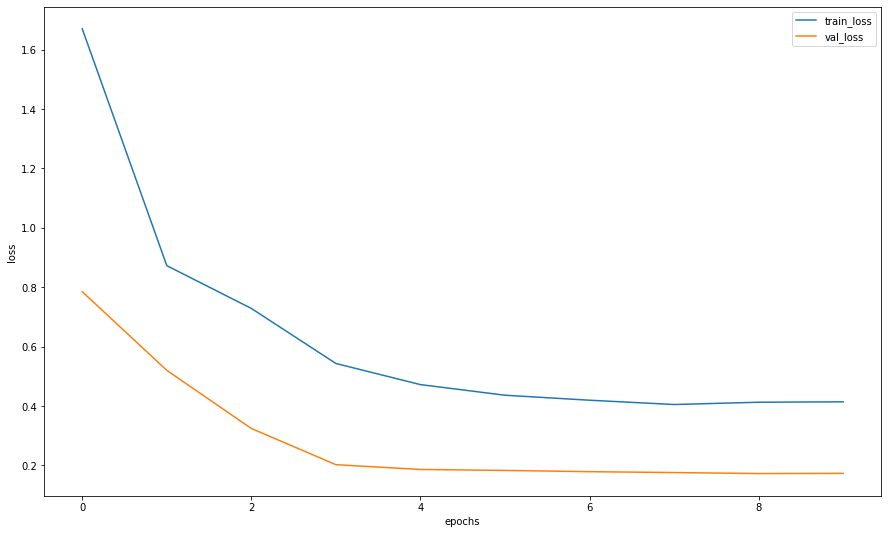

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# VGG 16: Let's calculate F1 score on VAL dataset

idxs = list(range(len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(vgg16_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

# we need to use label_encoder here, otherwise F1 score returns an error
actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

#adding average='micro', otherwise F1 score cannot be calculated
print('VGG 16 BN F1 score:', f1_score(actual_labels, preds_class, average='micro'))

VGG 16 BN F1 score: 0.96159724875812


Wow! Result is much better. Let's try something else

### Part 3 - ResNet 152 and Transfer Learning

In [ ]:
#let's download the largest ResNet which is ResNet 152

resnet_model = models.resnet152(pretrained=True)

print(resnet_model)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
n_classes = len(np.unique(train_val_labels))

# Tried just FC params adjusting with all features freezed
# Best Results with Number of params to unfreeze from the tail = 40
layers_to_unfreeze = 40

if layers_to_unfreeze > 0:
    for param in list(resnet_model.parameters())[:-layers_to_unfreeze]:
        param.requires_grad = False
else:
    # let's try to freeze all pretrained weights in ResNet
    for param in resnet_model.parameters():
        param.requires_grad = False

# replacing FC layer to match the required output = 42
resnet_model.fc = nn.Linear(2048, n_classes)

if train_on_gpu:
    resnet_model = resnet_model.cuda()

if layers_to_unfreeze > 0:
    opt_params = list(resnet_model.parameters())[-layers_to_unfreeze:]
else:
    opt_params = list(resnet_model.fc.parameters())

custom_opt = torch.optim.AdamW(opt_params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, amsgrad = True)

print("we will classify :{}".format(n_classes))
print(resnet_model)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

In [ ]:
# let's check which parameters we learn !!!
params_to_update = resnet_model.parameters()
print("ResNet 152 Params to learn:")

params_to_update = []
for name, param in resnet_model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Here we print out number of params
# passed to optimizer to learn 
print('\nResNet 152 opt params size =', 
      len(custom_opt.__getstate__()['param_groups'][0]['params']))

ResNet 152 Params to learn:
	 layer3.35.bn1.weight
	 layer3.35.bn1.bias
	 layer3.35.conv2.weight
	 layer3.35.bn2.weight
	 layer3.35.bn2.bias
	 layer3.35.conv3.weight
	 layer3.35.bn3.weight
	 layer3.35.bn3.bias
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.conv3.weight
	 layer4.0.bn3.weight
	 layer4.0.bn3.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.1.conv3.weight
	 layer4.1.bn3.weight
	 layer4.1.bn3.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias

ResNet 152 opt params size = 40


Let's run the training loop

In [ ]:
resnet_model, history = train(train_dataset, val_dataset, model=resnet_model, epochs=10, batch_size=64, \
                               use_scheduler = True, opt = custom_opt)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train epoch 0::   0%|          | 0/264 [00:00<?, ?it/s]

loss 1.0833714861265122


eval epoch 0::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 001 train_loss: 1.0834     val_loss 0.3782 train_acc 0.7245 val_acc 0.9052,     best_val_acc 0.9052


train epoch 1::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.5825817982732068


eval epoch 1::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 002 train_loss: 0.5826     val_loss 0.2891 train_acc 0.8439 val_acc 0.9232,     best_val_acc 0.9232


train epoch 2::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.4784750223018672


eval epoch 2::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 003 train_loss: 0.4785     val_loss 0.2130 train_acc 0.8718 val_acc 0.9478,     best_val_acc 0.9478


train epoch 3::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.3424242143237263


eval epoch 3::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 004 train_loss: 0.3424     val_loss 0.1450 train_acc 0.9099 val_acc 0.9677,     best_val_acc 0.9677


train epoch 4::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.3168575736307893


eval epoch 4::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 005 train_loss: 0.3169     val_loss 0.1366 train_acc 0.9154 val_acc 0.9681,     best_val_acc 0.9681


train epoch 5::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.30230101869987575


eval epoch 5::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 006 train_loss: 0.3023     val_loss 0.1285 train_acc 0.9216 val_acc 0.9698,     best_val_acc 0.9698


train epoch 6::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.29302799355422793


eval epoch 6::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 007 train_loss: 0.2930     val_loss 0.1277 train_acc 0.9215 val_acc 0.9717,     best_val_acc 0.9717


train epoch 7::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.2904207223475632


eval epoch 7::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 008 train_loss: 0.2904     val_loss 0.1264 train_acc 0.9231 val_acc 0.9708,     best_val_acc 0.9717


train epoch 8::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.2893541655515065


eval epoch 8::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 009 train_loss: 0.2894     val_loss 0.1264 train_acc 0.9253 val_acc 0.9698,     best_val_acc 0.9717


train epoch 9::   0%|          | 0/264 [00:00<?, ?it/s]

loss 0.2750209079281964


eval epoch 9::   0%|          | 0/82 [00:00<?, ?it/s]


Epoch 010 train_loss: 0.2750     val_loss 0.1286 train_acc 0.9260 val_acc 0.9710,     best_val_acc 0.9717


What about the Learning curves?

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

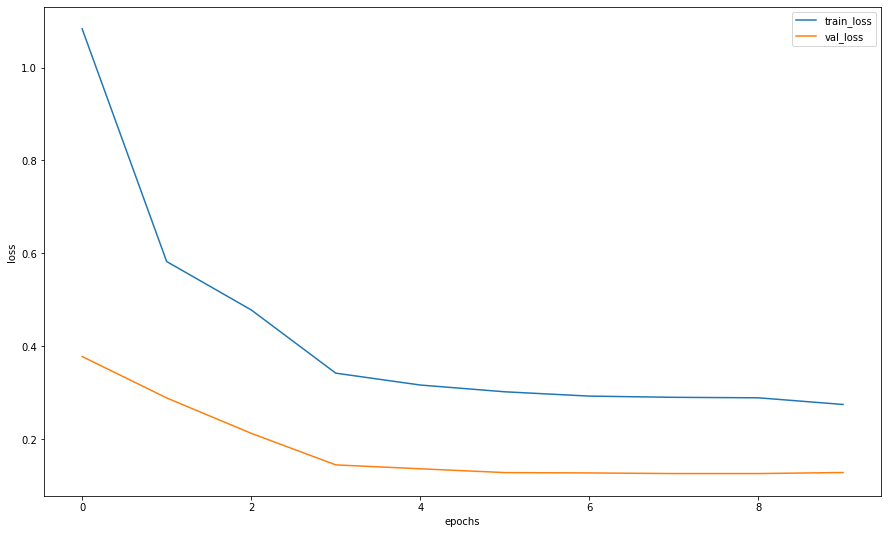

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# ResNet 152: Let's calculate F1 score on VAL dataset

idxs = list(range(len(val_dataset)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(resnet_model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

# we need to use label_encoder here, otherwise F1 score returns an error
actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

#adding average='micro', otherwise F1 score cannot be calculated
print('ResNet 152 F1 score:', f1_score(actual_labels, preds_class, average='micro'))

ResNet 152 F1 score: 0.9717233473442873


In [ ]:
# ResNet shows best results
# that's why let's use it as a target model

target_model = resnet_model

### What is the final test score?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

To make final prediction for test dataset, we should switch the model to "eval" mode. 

Also, we know that output layer of our model uses softmax, which returns the vector of probabilities, that sample belongs to one class or another. Let's use it!  

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Prediction for one picture"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Here let's look at the % of correct predictions for each class separately.

In [ ]:
list_valid = [(l, int(preds_class[i] == l)) for i, l in enumerate(actual_labels)]
list_valid = sorted(list_valid, key=itemgetter(0))
list_valid_grouper = groupby(list_valid, key=itemgetter(0))

# creating dictionary where key = class, value = count of correct predictions in sample
dct_all_samples = {k: v for k, v in zip(*np.unique(actual_labels, return_counts = True))}

dct_list_valid = {k: sum(map(itemgetter(1), v)) for k, v in list_valid_grouper}

dct_list_valid_percentage = {k: 100 * v // dct_all_samples[k] for k, v in dct_list_valid.items()}

#printing the percentage of valid predictions per class
dct_list_valid_percentage

{'abraham_grampa_simpson': 97,
 'agnes_skinner': 90,
 'apu_nahasapeemapetilon': 97,
 'barney_gumble': 80,
 'bart_simpson': 97,
 'carl_carlson': 95,
 'charles_montgomery_burns': 95,
 'chief_wiggum': 97,
 'cletus_spuckler': 83,
 'comic_book_guy': 94,
 'disco_stu': 50,
 'edna_krabappel': 97,
 'fat_tony': 100,
 'gil': 71,
 'groundskeeper_willie': 96,
 'homer_simpson': 98,
 'kent_brockman': 98,
 'krusty_the_clown': 99,
 'lenny_leonard': 94,
 'lionel_hutz': 100,
 'lisa_simpson': 97,
 'maggie_simpson': 87,
 'marge_simpson': 97,
 'martin_prince': 77,
 'mayor_quimby': 91,
 'milhouse_van_houten': 98,
 'miss_hoover': 100,
 'moe_szyslak': 98,
 'ned_flanders': 98,
 'nelson_muntz': 98,
 'otto_mann': 87,
 'patty_bouvier': 94,
 'principal_skinner': 97,
 'professor_john_frink': 81,
 'rainier_wolfcastle': 100,
 'ralph_wiggum': 100,
 'selma_bouvier': 96,
 'sideshow_bob': 97,
 'sideshow_mel': 100,
 'snake_jailbird': 92,
 'troy_mcclure': 100,
 'waylon_smithers': 82}

Here let's do cool visualization to see the actual character and model prediction. Also, let's add % of probability to demonstrate whether model is sure enough or not.

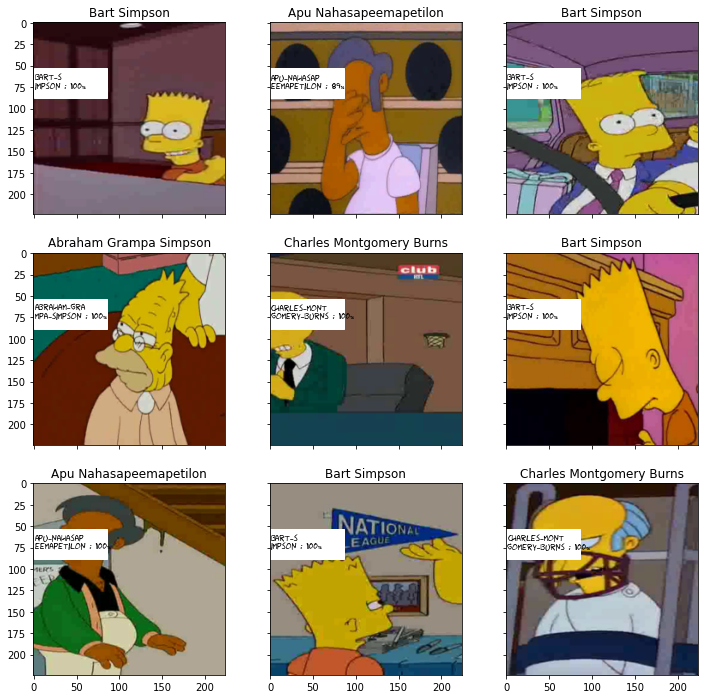

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(target_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submitting to Kaggle

Dataset does not contain labels for test data, so I can check final test score ONLY using Kaggle competition. 

Requested F1 score for Test dataset is 0.97

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(target_model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/My Drive/ML/submission_resnet_152_apr_28_try_21.csv', index=False)

Submit on Kaggle:
**Score = 0.98**


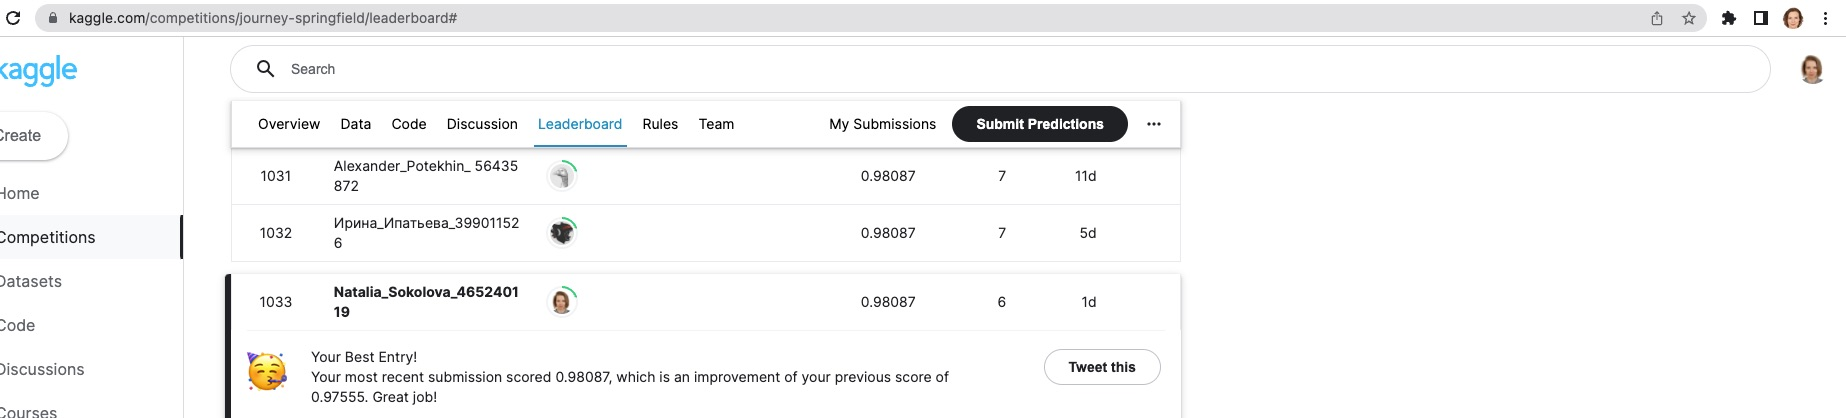

Wow! Great job 🙂